# Predict the energy landscape

### Boilerplate

In [1]:
%load_ext nb_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib notebook
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/hinges
dig86


<IPython.core.display.Javascript object>

### Figure out why folding funnels have a large energy gap between the relaxed inputs and the decoys 

In [2]:
import bz2
from copy import deepcopy
import io
from io import StringIO
import logging

logging.basicConfig(level=logging.INFO)
import math
import re
import subprocess

from matplotlib.widgets import Button
from matplotlib.text import Annotation
import IPython.core.display

IPython.core.display.display(
    IPython.core.display.HTML("<style>.container { width:100% !important; }</style>")
)
from IPython.display import Image
from IPython.display import clear_output
import ipywidgets as widgets

sys.path.append("/home/rdkibler/scripts/silent_tools/")
import silent_tools

pyrosetta.init("-mute all")


# can't see outputs? See here: https://stackoverflow.com/questions/36351109/ipython-notebook-ipywidgets-does-not-show

# Here's a version that does the picking and showing in different cells


class PointKeeper:
    def __init__(self, mom):
        self.mom = mom
        self._selections = pd.DataFrame(
            columns=list(set.union(*[set(x.columns) for x in self.mom.dfs.values()]))
            + ["name"]
        )

    def __call__(self, event):
        with self.mom.output:
            print("PICK")
            clear_output()
            # print("PREVIOUS")
            # print(self._selections[['description']])

            # what dataset did I come from?
            name = self.mom.scattermap[event.artist]
            # print("artist: ",name)
            dataset = self.mom.dfs[name]

            all_picked = dataset.iloc[event.ind].copy()
            # print(all_picked)
            # let's be safe about two decoys having the same name in two datasets
            all_picked["name"] = name

            # print("before",all_picked)
            # subtract things already selected so you can pick many things from the same area
            # all_picked = all_picked[~all_picked[['description','name']].isin(self._selections[['description','name']])]
            all_picked = pd.concat([all_picked, self._selections]).drop_duplicates(
                keep=False
            )

            # print("after",all_picked)

            if not all_picked.empty:

                min_picked = all_picked.loc[all_picked["score"].idxmin()]
                picked = min_picked.copy()
                self._selections = self._selections.append(
                    picked, sort=True
                ).drop_duplicates(keep=False)
                # print("NOW")
            print(self._selections[["description", "score", "rms", "name"]])

    def clear_selections(self):
        self._selections = self._selections.drop(self._selections.index)

    def selections(self):
        return self._selections


class Biff:
    def __init__(self):
        self.fig = None
        self.dfs = {}
        self.colors = {}
        self.indices = {}
        self.filenames = {}
        self.output = widgets.Output()

    def load_silent_file(self, filename, name=None, color=None):
        if name == None:
            name = os.splitext(os.basename(filename))[0]

        score_df = self.extract_scores(filename)
        index = silent_tools.get_silent_index(filename)
        self.add_df(score_df, name, color=color)

        # self.dfs[name] = score_df
        self.indices[name] = index
        self.filenames[name] = filename

    def extract_scores(self, in_silent):
        scraped_score_file = in_silent + ".sc"
        command = ["grep", "SCORE:", in_silent]

        process = subprocess.Popen(command, stdout=subprocess.PIPE)
        # print(type(process.stdout))
        encoded_output = io.TextIOWrapper(process.stdout)
        # print(type(encoded_output))

        df = pd.read_csv(
            encoded_output,
            delim_whitespace=True,
            skiprows=0,
            header=0,
            warn_bad_lines=True,
            error_bad_lines=False,
            skip_blank_lines=True,
        )

        return df

    def show_picks():
        poses, colors = get_selected_poses(get_colors=True)
        if poses:

            for pose in poses[1:]:
                pyrosetta.rosetta.core.scoring.calpha_superimpose_pose(pose, poses[0])
            viewer = py3Dmol.view(*(600, 400))
            # colors = ["#FF0000","#00FF00","#0000FF","#FF00FF","#FFFF00","#00FFFF","#FFFFFF","#000000"]
            for pose, color in zip(poses, colors):
                pdb_str = pyrosetta.distributed.io.to_pdbstring(pose)
                # viewer.addAsOneMolecule(pdb_str,'pdb')
                viewer.addModel(pdb_str, "pdb")
                viewer.setStyle({"model": -1}, {"cartoon": {"color": color}})

            # viewer.setStyle(
            #            {"cartoon": {"color": "blue"}, "stick": {"radius": 0.25}}
            #        )
            viewer.setStyle(
                {"hetflag": True},
                {
                    "stick": {
                        "singleBond": False,
                        "colorscheme": "whiteCarbon",
                        "radius": 0.25,
                    }
                },
            )
            viewer.zoomTo()
            viewer.show()
        else:
            print("no decoys selected")

    def get_selected_poses(self, get_colors=False):
        poses = []
        colors = []

        # tags = pyrosetta.Vector1(self.get_picked()[['description','name']])
        tags = self.get_picked()[["description", "name"]]

        if not tags.empty:
            for name in tags["name"].unique():
                print(name)

                silent_lines = []
                these_tags = tags[tags["name"] == name]
                descriptions = pyrosetta.Vector1(list(these_tags["description"]))
                # colors += these_tags['color']
                colors += self.colors[name]
                silent_lines += silent_tools.get_silent_structures(
                    self.filenames[name], self.indices[name], descriptions
                )

                sfo = pyrosetta.rosetta.core.io.silent.SilentFileOptions()
                sfd = pyrosetta.rosetta.core.io.silent.SilentFileData(sfo)
                header = silent_tools.silent_header(self.indices[name])
                header += "REMARK BINARY SILENTFILE\n"

                silent_file_text = "".join(
                    [header] + ["".join(s) for s in silent_lines]
                )
                lines_stream = pyrosetta.rosetta.std.istringstream(silent_file_text)
                sfd.read_stream(
                    lines_stream,
                    pyrosetta.Vector1(descriptions),
                    throw_exception_on_bad_structs=True,
                )

                for tag in descriptions:
                    pose = pyrosetta.Pose()

                    sfd.get_structure(tag).fill_pose(pose)
                    poses.append(pose)
        if get_colors:
            return poses, colors
        else:
            return poses

    def add_df(self, df, name, color=None):
        if color == None:
            color = self.color_generator()

        self.colors[name] = color
        self.dfs[name] = df.copy()

    def color_generator(self, colors_to_avoid):
        print("color_generator not implemented")
        return "purple"

    def show_interactive(self):
        if not self.fig:
            self.fig = plt.figure()
        line_to_show = widgets.HTML()

        plottable_col = set.intersection(*[set(df.columns) for df in self.dfs.values()])
        # print(plottable_col)

        # print("make button")
        button = widgets.Button(
            description="Reset Selection",
            disabled=False,
            button_style="",  # 'success', 'info', 'warning', 'danger' or ''
            tooltip="Click me",  # ,
        )

        # print("init pk")
        self.pk = PointKeeper(self)

        # fig.canvas.mpl_connect('key_press_event', on_key_press)
        # fig.canvas.mpl_connect('key_release_event', on_key_release)

        # print("attach pk")
        self.fig.canvas.mpl_connect("pick_event", self.pk)
        # print("attach status widget")
        display(line_to_show)
        # print("attach button")
        display(button, self.output)
        # print("attach output")
        display(self.output)

        def on_button_clicked(b):
            with self.output:
                clear_output()
                print("selection cleared!", end="\r")
                self.pk.clear_selections()

        # print("attach button callback")
        button.on_click(on_button_clicked)
        # print("begin plot")
        display(widgets.interactive(self.show_plot, X=plottable_col, Y=plottable_col))

    def get_picked(self):
        return self.pk.selections()

    def show_picked(self):

        poses = self.get_selected_poses()
        if poses:

            for pose in poses[1:]:
                pyrosetta.rosetta.core.scoring.calpha_superimpose_pose(pose, poses[0])
            viewer = py3Dmol.view(*(600, 400))
            colors = [
                "#FF0000",
                "#00FF00",
                "#0000FF",
                "#FF00FF",
                "#FFFF00",
                "#00FFFF",
                "#FFFFFF",
                "#000000",
            ]
            for pse, color in zip(poses, colors):
                pdb_str = pyrosetta.distributed.io.to_pdbstring(pse)
                # viewer.addAsOneMolecule(pdb_str,'pdb')
                viewer.addModel(pdb_str, "pdb")
                viewer.setStyle({"model": -1}, {"cartoon": {"color": color}})

            # viewer.setStyle(
            #            {"cartoon": {"color": "blue"}, "stick": {"radius": 0.25}}
            #        )
            viewer.setStyle(
                {"hetflag": True},
                {
                    "stick": {
                        "singleBond": False,
                        "colorscheme": "whiteCarbon",
                        "radius": 0.25,
                    }
                },
            )
            viewer.zoomTo()
            viewer.show()
        else:
            print("no decoys selected")

    def show_plot(self, X="rms", Y="score"):
        with self.output:
            # print("HELLO! THIS IS ME, YOUR PLOTTER")
            #####self.fig = plt.figure()

            ax = self.fig.add_subplot(1, 1, 1)
            # plt.scatter(  df_abinitio.loc[:, [X]],df_abinitio.loc[:, [Y]], marker='.', edgecolors='none', picker=True, cmap='RdYlGn' )

            self.scattermap = {}
            for name in self.dfs.keys():
                # print(name)
                self.scattermap[
                    ax.scatter(
                        self.dfs[name][X],
                        self.dfs[name][Y],
                        marker=".",
                        picker=True,
                        c=self.colors[name],
                    )
                ] = name
            # print(self.scattermap)

            ax.set_title(Y + " vs " + X)
            ax.set_xlabel(X)
            ax.set_ylabel(Y)

            ax.grid()
            self.fig.show()
            # self.fig.canvas.draw_idle()
            # print("DONE!")

INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


<IPython.core.display.Javascript object>

Warning!!! Unable to save index file. Must reindex every time!


<IPython.core.display.Javascript object>


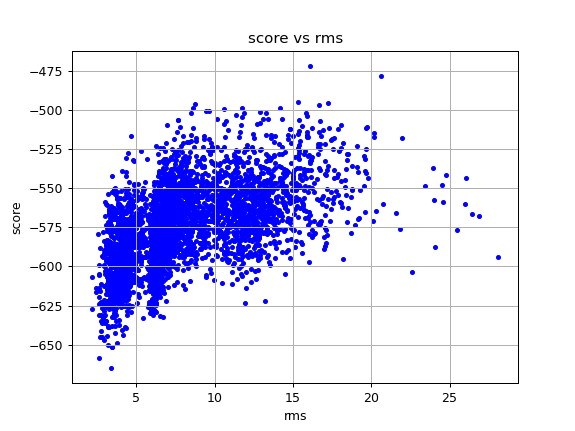

HTML(value='')

Button(description='Reset Selection', style=ButtonStyle(), tooltip='Click me')

Output()

Output()

interactive(children=(Dropdown(description='X', index=33, options=('fa_intra_rep_xover4', 'lk_ball_iso', 'fa_a…

<IPython.core.display.Javascript object>

In [8]:
wd = "/projects/boinc-results/1398971/"
abinitio_silentfile = (
    wd
    + "pf20210628_TEST_Y_d1448ab3e8c0db9a65ec06edc14bd96f15aab148a1b00d71_Y_nocys_fragments_abinitio_SAVE_ALL_OUT_1398971_0.all.out"
)
relax_silentfile = (
    wd
    + "pf20210628_TEST_Y_d1448ab3e8c0db9a65ec06edc14bd96f15aab148a1b00d71_Y_nocys_fragments_relax_SAVE_ALL_OUT_1398971_0.all.out"
)
ff = Biff()
ff.load_silent_file(abinitio_silentfile, "predicted", "blue")
# ff.load_silent_file(relax_silentfile, "relax", "green")

ff.show_interactive()

In [5]:
test = ff.get_picked()
test.head()

,Filter_Stage2_aBefore,Filter_Stage2_bQuarter,Filter_Stage2_cHalf,Filter_Stage2_dEnd,SCORE:,clashes_bb,clashes_total,co,description,dslf_fa13,...,maxsub,name,omega,p_aa_pp,pro_close,rama_prepro,ref,rms,score,time
2177,0.0,0.0,0.0,0.0,SCORE:,0.0,0.0,18.883,S_0000001600016_0000199_0,0.0,...,184.0,docking,9.222,-34.851,0.636,1.106,-112.782,1.866,-529.378,1178.0
1450,0.0,0.0,0.0,0.0,SCORE:,0.0,0.0,18.351,S_0000002200022_0000115_0,0.0,...,184.0,docking,8.954,-35.953,0.963,2.736,-112.782,1.762,-537.476,1752.0
45,NaN,NaN,NaN,NaN,SCORE:,NaN,NaN,NaN,00001_0002300023_0000002_0,0.0,...,184.0,relax,4.002,-41.265,0.362,-11.414,-112.782,0.696,-633.253,1079.0


<IPython.core.display.Javascript object>

In [12]:
len(test)

8

<IPython.core.display.Javascript object>

In [ ]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

scores = "fa_atr fa_dun_dev fa_dun_rot fa_dun_semi fa_elec fa_intra_atr_xover4 fa_intra_elec fa_intra_rep_xover4 fa_intra_sol_xover4 fa_rep fa_sol gen_bonded hbond_bb_sc hbond_lr_bb hbond_sc hbond_sr_bb hxl_tors lk_ball lk_ball_bridge lk_ball_bridge_uncpl lk_ball_iso maxsub omega p_aa_pp pro_close rama_prepro ref rms score time".split()

nc = 5
nr = int(np.ceil(len(scores) / nc))
plt.close()
fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(3 * nc, 3 * nr))
ax = ax.flatten()
for i, term in enumerate(scores):
    sns.violinplot(ax=ax[i], x="name", y=term, data=test)
    ax[i].set(title=term) #$ylabel="", yticks=[])
    
plt.tight_layout()
plt.savefig(f"figs/07_all_scoreterms.png")

# for term in scores:
#     plt.close()
#     sns.violinplot(x="name", y=term, data=test)
#     plt.savefig(f"figs/07_{term}.png")



In [4]:
# print(test.loc[125])

<IPython.core.display.Javascript object>

### Curate pdbs with excellent forward folding funnels
We are looking for stuff that has two minima that are low in energy, where one corresponds to state X and one corresponds to state Y


### Get features 
Use original trRosetta? At the very least it is helpful if the model spits out multiple discrete predictions, ideally on a per residue basis

In [ ]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd


def featurize(abspath):
    import os, subprocess

    def cmd(command, wait=True):
        """@nrbennet @bcov"""
        the_command = subprocess.Popen(
            command,
            shell=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            universal_newlines=True,
        )
        if not wait:
            return
        the_stuff = the_command.communicate()
        return str(the_stuff[0]) + str(the_stuff[1])

    working_dir = os.path.dirname(abspath)
    pythonpath = "/software/conda/envs/tensorflow/bin/python"
    script = os.path.join(os.getcwd(), "predict_.py")
    pdb2fasta = os.path.join(os.getcwd(), "pdb2fasta.sh")
    pdb = os.path.basename(abspath)
    handle = pdb.replace("pdb", "fasta")
    to_send = f"""cd {working_dir}; {pdb2fasta} {pdb} > {handle} ;"""
    to_send += f""" {pythonpath} {script} -i {handle} -o "/net/scratch/pleung/" """
    print("sending: ", to_send)
    cmd(to_send)
    return


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

futures = []

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="long",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-510 workers,
        cluster.adapt(
            minimum=1,
            maximum=510,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            with open(
                os.path.join(os.getcwd(), "05_filter", "1trp_good.list"), "r"
            ) as f:
                for pdb in f:
                    future = client.submit(featurize, pdb.rstrip())
                    futures.append(future)
            results = [pending.result() for pending in futures]